In [1]:
import os
import sys
from PIL import Image
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import albumentations as A

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

device="cuda"

In [2]:
import os
path="e:/kaggle_data/SETI Breakthrough Listen - E.T. Signal Search/"
files=os.listdir(path)
import sys
sys.path.append('e:/kaggle_data/timm')
import timm

In [3]:
df=pd.DataFrame(files,columns=["file"])
df["file_path"]=df["file"].apply(lambda x: path+x)
sample_submission=pd.read_csv(df.file_path[0])
train=pd.read_csv(df.file_path[1])

# covert image id 2 path

In [4]:
def convert_image_id_2_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "e:/kaggle_data/SETI Breakthrough Listen - E.T. Signal Search/{}/{}/{}.npy".format(
        folder, image_id[0], image_id 
    )

In [5]:
train["path"]=train["id"].apply(lambda x: convert_image_id_2_path(x))
train

,id,target,path,fold,preds
0,0000799a2b2c42d,0,e:/kaggle_data/SETI Breakthrough Listen - E.T....,4,-2.043302
1,00042890562ff68,0,e:/kaggle_data/SETI Breakthrough Listen - E.T....,0,-2.146094
2,0005364cdcb8e5b,0,e:/kaggle_data/SETI Breakthrough Listen - E.T....,1,-2.450732
3,0007a5a46901c56,0,e:/kaggle_data/SETI Breakthrough Listen - E.T....,3,-2.085825
4,0009283e145448e,0,e:/kaggle_data/SETI Breakthrough Listen - E.T....,0,-2.452686
...,...,...,...,...,...
59995,fff8217fe05aba3,0,e:/kaggle_data/SETI Breakthrough Listen - E.T....,3,-4.570417
59996,fffa939e610ed70,0,e:/kaggle_data/SETI Breakthrough Listen - E.T....,1,-4.497925
59997,fffbb1c9c3d6c31,1,e:/kaggle_data/SETI Breakthrough Listen - E.T....,3,-3.042268
59998,fffc9a763d23647,0,e:/kaggle_data/SETI Breakthrough Listen - E.T....,1,-2.603292


<AxesSubplot:xlabel='target', ylabel='count'>

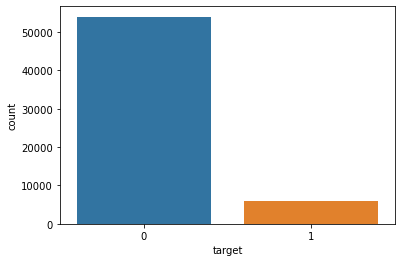

In [6]:
sns.countplot(data=train,x="target")

In [7]:
def sigmoid(x):
    return 1 / (1 +np.exp(-x))
train["level"]=train.preds.apply(lambda x: sigmoid(x))

def make_label(x):
    return np.int16(x*100)
train["label"]=train.level.apply(lambda x:make_label(x))

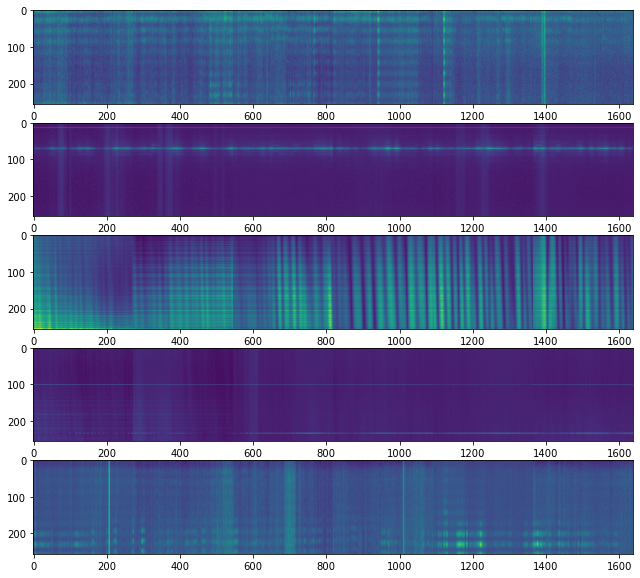

In [8]:
f,ax=plt.subplots(5,1,figsize=(20,10))
for i in range(5):
    img=np.load(train.loc[i,"path"])#(6,273,256)
    img=img.astype(np.float32)
    img=np.vstack(img).transpose((1,0))#(1638,256)->(256,1638)
    ax[i].imshow(img)

# Data

In [9]:
import random
import os
def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(42)

In [10]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=5)
train["fold"]=-1
for i,(_,val_idx) in enumerate(skf.split(train.sample(frac=1.),train.label)):
    train.loc[val_idx,"fold"]=i 

# Data Loader

In [19]:
class SetiDataset(Dataset):
    def __init__(self, df, transform=None, conf=None):
        self.df = df.reset_index(drop=True)
        self.labels = df['label'].values
        self.dir_names = df['path'].values
        self.transform = transform
        self.conf = conf
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        file_path = self.df.loc[idx,"path"]
#1        
#         image = np.load(file_path)#(6,273,256)
#         image=np.vstack(img).transpose((1,0))#(1638,256)->(256,1638)
    
#         if self.transform is not None:
#             image = self.transform(image=image)['image']
        
#         image = torch.tensor(image,dtype=torch.float32)
#         label = torch.tensor([self.labels[idx]]).float()

#2 method
        image = np.load(file_path)
        image = image.astype(np.float32)
        image = np.vstack(image).transpose((1, 0))
        img_pl = Image.fromarray(image).resize((384, 384), resample=Image.BICUBIC)
        image = np.array(img_pl)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = torch.from_numpy(image).unsqueeze(dim=0)
        label = torch.tensor(self.labels[idx],dtype=torch.long)
        
        return {
            "x":image, 
            "y":label
        }

In [20]:
#dataset test
fold=0
train_df=train[train.fold!=fold].reset_index(drop=True)
valid_df=train[train.fold==fold].reset_index(drop=True)

In [21]:
train_dataset=SetiDataset(train_df)
valid_dataset=SetiDataset(valid_df)

In [22]:
#data loader
train_loader=torch.utils.data.DataLoader(
    train_dataset,batch_size=8,num_workers=0,shuffle=True
)
valid_loader=torch.utils.data.DataLoader(
    valid_dataset,batch_size=8,num_workers=0,shuffle=False
)

In [23]:
for a in train_loader:
    print(a["x"].shape, a["y"].shape)
    break

torch.Size([8, 1, 384, 384]) torch.Size([8])


# Model

In [27]:
class CFG:
    model_test=True
    frac=1.0#0.02 #1.0#
    train=True#False#
    pretrained=True #False#
#     model= "tf_efficientnet_b0"
    model= "resnet18"#"tf_efficientnet_b0"#"resnet18"
    train_bs=16
    valid_bs=8#12
    test_bs=8
    epoch=40
    fold=[0]
    seed= 719
    lr=2e-4
    es=4

In [28]:
## Model
import torch
import torch.nn as nn
import torchvision

def get_model(classes=1,pretrained=True):
    classes=classes
    base_model=timm.create_model(CFG.model, pretrained=pretrained, num_classes=100, in_chans=1)
    return base_model 

In [29]:
model=get_model()

In [30]:
def loss_fn(outputs,targets):
    # return nn.BCEWithLogitsLoss()(outputs,targets)
    return nn.CrossEntropyLoss()(outputs,targets)

In [31]:
if CFG.model_test:
    model.to(device)
    model.train()

    for a in train_loader:
        x=a["x"].to(device)
        y=a["y"].to(device)
        output=model(x)
        loss=loss_fn(output,y)
        break

    print(output.squeeze(-1).shape)

torch.Size([8, 100])


# Train Function

In [32]:
## Engine
from tqdm import tqdm
class Engine:
    def __init__(self,model,optimizer,scheduler=None):
        self.model=model
        self.optimizer=optimizer
        self.scheduler=scheduler
        self.device=device

    def loss_fn(self,outputs,targets):
        return nn.CrossEntropyLoss()(outputs,targets)        

    def train(self,data_loader):
        self.model.train()
        final_loss=0
        for data in tqdm(data_loader):
            self.optimizer.zero_grad()
            inputs=data["x"].to(self.device)
            targets=data["y"].to(self.device)
            outputs=self.model(inputs)
            loss=self.loss_fn(outputs,targets)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
        return final_loss/len(data_loader)
    
    def validate(self,data_loader):
        self.model.eval()
        final_loss=0
        for data in tqdm(data_loader):
            inputs=data["x"].to(self.device)
            targets=data["y"].to(self.device)
            outputs=self.model(inputs)
            loss=loss_fn(outputs,targets)
            final_loss += loss.item()
        return final_loss/len(data_loader)

In [33]:
def get_dataset(fold=0):
    train_df=train[train.fold!=fold].reset_index(drop=True).sample(frac=CFG.frac)
    valid_df=train[train.fold==fold].reset_index(drop=True).sample(frac=CFG.frac)

    train_dataset=SetiDataset(train_df)
    valid_dataset=SetiDataset(valid_df)

    train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=CFG.train_bs,num_workers=0,shuffle=True)
    valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=CFG.valid_bs,num_workers=0,shuffle=False)
    return train_loader,valid_loader

In [34]:
def loop_train(fold,save_model=False):
    # Dataset
    train_loader,valid_loader=get_dataset(fold)
    model=get_model()
    model.to("cuda")

    # Model,Optimizer, scheduler, engine
    optimizer=torch.optim.Adam(model.parameters(),lr=3e-4)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,patience=3,threshold=1e-5,mode="min",verbose=True)
    engine=Engine(model,optimizer,scheduler)
    best_loss=np.inf
    early_stopping=10
    early_stopping_cnt=0

    for epoch in range(CFG.epoch):
        train_loss=engine.train(train_loader)
        valid_loss=engine.validate(valid_loader)
        scheduler.step(valid_loss)

        if valid_loss<best_loss:
            best_loss=valid_loss
            torch.save(model.state_dict(),f"model_{CFG.model}_fold_{fold}.bin")
            print(f"fold={fold}, epoch={epoch}, train_loss={train_loss:.6f}, valid_loss={valid_loss:.6f}")    
            early_stopping_cnt=0
        else:
            early_stopping_cnt+=1
        if early_stopping_cnt>early_stopping:
            break

    print(f"fold={fold}, best val loss={best_loss}")

In [35]:
for fold in CFG.fold:
    print(f"fold :{fold}")
    loop_train(fold,save_model=True)

fold :0


  7%|▋         | 201/3000 [02:59<41:34,  1.12it/s]


KeyboardInterrupt: 